In [1]:
#Import Packages

from bs4 import BeautifulSoup as BS
import urllib.request
import pandas as pd

import pandas as pd
import numpy as np
import geopandas as gpd
import shapely.geometry
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
#Read in GeoJSONs with Geopandas

plates_gdf = gpd.read_file("MR_Data/PB2002_plates.json")
countries_gdf = gpd.read_file("MR_Data/countries.geojson")
earthquakes_gdf = gpd.read_file("MR_Data/earthquakes.GeoJSON")
volcanoes_gdf = gpd.read_file("MR_Data/volcanoes.GeoJSON")
vents_gdf = gpd.read_file("MR_Data/vents.GeoJSON")

fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
earthquakes_gdf.plot(ax=ax, markersize = 25, column = "Magnitude", cmap = "rainbow", marker = "x")
volcanoes_gdf.plot(ax=ax, markersize = 25, column = "Type", cmap = "rainbow", marker = "^")
vents_gdf.plot(ax=ax, markersize = 25, column = "Depth", cmap = "rainbow", marker = "|")

earthquakes_gdf

volcanoes_gdf.head(1)

vents_gdf.head(1)

eruptions = pd.read_table("MR_Data/volerup.txt")

#eruptions
eruptions.info()

eruptions = eruptions.drop(["TOTAL_HOUSES_DESTROYED_DESCRIPTION", "TOTAL_HOUSES_DESTROYED", "TOTAL_DAMAGE_DESCRIPTION", 
                            "TOTAL_DAMAGE_MILLIONS_DOLLARS", "TOTAL_INJURIES_DESCRIPTION", "TOTAL_INJURIES", 
                            "TOTAL_MISSING_DESCRIPTION", "TOTAL_MISSING", "TOTAL_DEATHS_DESCRIPTION", 
                            "HOUSES_DESTROYED_DESCRIPTION", "HOUSES_DESTROYED", "DAMAGE_DESCRIPTION", 
                            "DAMAGE_MILLIONS_DOLLARS", "INJURIES_DESCRIPTION", "INJURIES", "MISSING_DESCRIPTION", 
                            "MISSING", "DEATHS_DESCRIPTION", "DEATHS", "Agent"], axis = 1)
#geometry_erupt = [Point(xy) for xy in zip(eruptions.Longitude, eruptions.Latitude)]
#crs = {"init": "epsg:4326"} 
#eruptions_gdf = gpd.GeoDataFrame(eruptions, crs=crs, geometry=geometry_erupt)

eruptions_gdf

def web_scraper(url, class_):
    request = urllib.request.Request(url)
    result = urllib.request.urlopen(request)
    resulttext = result.read()
    soup = BS(resulttext, 'html.parser')
    table = soup.find_all('table', class_=class_)
    table_2 = table[0]
    table_headers = table_2.find_all("th")
    columns = [th.text for th in table_headers]
    rows = []
    for tr in table_2.find_all("tr")[1:]:
        row_data = [td.text for td in tr.find_all("td")]
        rows.append(row_data)
    return pd.DataFrame(rows, columns = columns)

earthquakes_2 = WebScraper(
    "https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900", 
    "sortable wikitable", earthquakes_2)
print(earthquakes_2)

request = urllib.request.Request("https://en.wikipedia.org/wiki/List_of_large_volcanic_eruptions_of_the_20th_century")
result = urllib.request.urlopen(request)
resulttext = result.read()
soup = BS(resulttext, 'html.parser')
table = soup.find_all('table', class_="wikitable sortable")
table_2 = table[0]
#table_2
table_headers = table_2.find_all("th")[1:5]
#table_headers
columns = [th.text for th in table_headers]
rows = []
for tr in table_2.find_all("tr")[1:]:
    row_data = [td.text for td in tr.find_all("td")]
    rows.append(row_data)
eruptions_2 = pd.DataFrame(rows, columns = columns)

test = "(\[\d+\])"
eruptions_2["Volcano (eruption)"] = eruptions_2["Volcano (eruption)"].str.replace(test, "")
eruptions_2.columns = ["Name", "Year", "Casualties", "Notes"]
eruptions_2.head()

#volcanoes_gdf.info()
#cols = ["Country", "Type", "lat", "lng", "Elevation", "geometry"]
volcanoes_2 = volcanoes_gdf.drop(["Country", "Type", "Elevation", "geometry"], axis = 1)
volcanoes_2.columns = ["Name", "lat", "lng"]

volcanoes["lat"] = volcanoes["lat"].astype(str)
volcanoes["lng"] = volcanoes["lng"].astype(str)

volcanoes.info()

eruptions_2.info()

eruptions_2["Name"] = eruptions_2["Name"].str.strip()

eruptions_2[eruptions_2["Name"].str.contains("Alaid")]

volcanoes_2[volcanoes_2["Name"].str.contains("Alaid")]

#eruptions_new["lat"] = volcanoes_2["Name"].map(volcanoes_2.set_index("Name")["lat"])
eruptions_new = eruptions_2.merge(volcanoes_2, how = "left", on = "Name")
eruptions_new_notnull = eruptions_new[eruptions_new["lat"].notnull()]
#len(eruptions_new_notnull)
#eruptions_new
eruptions_new_notnull

geometry_erupt_new = [Point(xy) for xy in zip(eruptions_new.lng, eruptions_new.lat)]
crs = {"init": "epsg:4326"}
eruptions_new_gdf = gpd.GeoDataFrame(eruptions_new, crs=crs, geometry=geometry_erupt_new)
eruptions_new_gdf

request = urllib.request.Request("https://en.wikipedia.org/wiki/List_of_submarine_volcanoes")
result = urllib.request.urlopen(request)
resulttext = result.read()
soup = BS(resulttext, 'html.parser')
table = soup.find_all('table', class_="wikitable sortable")
table_2 = table[0]
#table_2
table_headers = table_2.find_all("th")
#table_headers
columns = [th.text for th in table_headers]
rows = []
for tr in table_2.find_all("tr")[1:]:
    row_data = [td.text for td in tr.find_all("td")]
    rows.append(row_data)
submarine = pd.DataFrame(rows, columns = columns)

submarine

spade = "(\d*♠)"
submarine["Summit Elevation"]=submarine["Summit Elevation"].str.replace(spade, "")
submarine["Approximate elevation above seafloor"]=submarine["Approximate elevation above seafloor"].str.replace(spade, "")

submarine

coord_ms = "(.*/.*/)"
submarine["Location"]=submarine["Location"].str.replace(coord_ms, "")

submarine

submarine[['lat','lng']] = submarine['Location'].str.split(';',expand=True)

submarine["lat"] = submarine["lat"].str.strip()
submarine["lng"] = submarine["lng"].str.strip()
submarine["lat"] = pd.to_numeric(submarine["lat"])
submarine["lng"] = pd.to_numeric(submarine["lng"])

submarine

geometry_sub = [Point(xy) for xy in zip(submarine.lng, submarine.lat)]
crs = {"init": "epsg:4326"}
submarine_gdf = gpd.GeoDataFrame(submarine, crs=crs, geometry=geometry_sub)
submarine_gdf.head(1)

submarine_gdf.plot()

#encoding for "utf-8"
#tsunamis = pd.read_table("MR_Data/tsevent.txt", encoding = "ISO-8859-1")

tsunamis_2 = pd.read_csv("MR_Data/tsunamis.csv")
tsunamis_2 = tsunamis_2.drop("Unnamed: 0", axis = 1)
tsunamis_2.columns = ["Year", "Month", "Day", "Focal_Depth", "Magnitude", "Country", "Location", "lat", "lng", "Max_Water_Height", "Deaths", "Total_Deaths"]
tsunamis_2 = tsunamis_2.drop(0)
#tsunamis_2
#tsunamis_2["lat"] = pd.to_numeric(tsunamis_2["lat"])
#tsunamis_2["lng"] = pd.to_numeric(tsunamis_2["lng"])
#geometry_t = [Point(xy) for xy in zip(tsunamis_2.lng, tsunamis_2.lat)]
#crs = {"init": "epsg:4326"}
#tsunamis_gdf = gpd.GeoDataFrame(tsunamis_2, crs=crs, geometry=geometry_t)
#tsunamis_gdf.head()

DD = d + (min/60) + (sec/3600)

fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
#earthquakes_gdf.plot(ax=ax, markersize = 25, column = "Magnitude", cmap = "rainbow", marker = "x")
#volcanoes_gdf.plot(ax=ax, markersize = 5, color = "red") #, column = "Type", cmap = "rainbow", marker = "^")
#vents_gdf.plot(ax=ax, markersize = 25, column = "Depth", cmap = "rainbow", marker = "|")
#eruptions_gdf.plot(ax=ax, markersize = 5, color = "orange") #, column = "Elevation", cmap = "rainbow", marker = "^")
#submarine_gdf.plot(ax=ax, markersize = 15, color = "green")
#eruptions_new_gdf.plot(ax=ax, markersize = 5, color = "b")
tsunamis_gdf.plot(ax=ax, markersize = 5, color = "purple")

earthquakes_gdf.head(1)

volcanoes_gdf.head(1)

submarine_gdf.head(1)

eruptions_gdf.head(1)

eruptions_new_gdf.head(1)

tsunamis_gdf.head(1)

vents_gdf.head(1)

columns to drop:
Tsunamis = ["Country", "Location", :"Max_Water_Height"]
Vents = ["Name", "Activity", "Region", "Year&Discovered"]
Eruptions_new = ["Notes"]
Eruptions = ["Location", "Country", "Elevation", "Status", "Time"]

dfs to concat:
submarine and volcanoes

Things to fix:

Merge between eruptions_2 and volcanoes.

In [3]:
earthquakes2_gdf = gpd.read_file("MR_Data/earthquakes2.GeoJSON")
#eruptions_more_gdf = gpd.read_file("MR_Data/geoserver-GetFeature.application")

earthquakes2_gdf.head(1)

lat = []
lng = []
for point in earthquakes2_gdf["geometry"]:
    lng.append(point.x)
    lat.append(point.y)
#lat

earthquakes2 = earthquakes2_gdf.drop(["geometry", "place", "id"], axis = 1)
earthquakes2["lat"] = lat
earthquakes2["lng"] = lng
earthquakes2.head(15)

earthquakes2["date"] = earthquakes2["date"].apply(str)
year = "(\d\d\d\d)"
month = "(\d\d)"
earthquakes2["year"] = earthquakes2["date"].str.extract(year, expand = True)
earthquakes2["date"] = earthquakes2["date"].str[4:]
earthquakes2["month"] = earthquakes2["date"].str.extract(month, expand = True)
earthquakes2["date"] = earthquakes2["date"].str[2:]
earthquakes2.columns = ["Day", "Depth", "Mag", "lat", "lng", "Year", "Month"]
earthquakes2 = earthquakes2[["Year", "Month", "Day", "lat", "lng", "Mag", "Depth"]]
earthquakes2.head()
#for date in earthquakes2["date"]:
#    year_md = [date[i:i+4] for i in range(0, len(date), 4)]

#year_md

eruptions_more_gdf2 = eruptions_more_gdf.drop(["id", "VolcanoName", "VolcanoNumber", "StartDate", "EndDate", "Activity_ID", "geometry"], axis = 1)
eruptions = pd.DataFrame(eruptions_more_gdf2)
eruptions.head(1)

eruptions.columns = ["ExplosivityIndexMax", "Year", "Month", "Day", "End_Year", "End_Month", "End_Day", "Continuing", "lat", "lng"]
eruptions = eruptions[["Year", "Month", "Day", "lat", "lng", "ExplosivityIndexMax", "End_Year", "End_Month", "End_Day", "Continuing"]]
eruptions.head()

tsunamis_2 = tsunamis_2.drop(["Country", "Location"], axis = 1)
tsunamis_2 = tsunamis_2[["Year", "Month", "Day", "lat", "lng", "Magnitude", "Focal_Depth", "Max_Water_Height", "Deaths", "Total_Deaths"]]
#tsunamis_2.head()
tsunamis_2.shape

tsunamis_2[tsunamis_2["lat"].isnull()]

tsunamis_3 = tsunamis_2.drop(tsunamis_2[tsunamis_2["lat"].isnull()].index)

tsunamis_3.head(100)

#tsunamis_3[tsunamis_3["Year"]=="1900"]
tsunamis_4 = tsunamis_3[tsunamis_3.index>=1345]
tsunamis_4
#tsunamis_3[tsunamis_3.index>=1344]

earthquakes2.to_json("JSONs_for_TP/earthquakes2.json")
eruptions.to_json("JSONs_for_TP/eruptions.json")
tsunamis_4.to_json("JSONs_for_TP/tsunamis.json")

In [4]:
boundaries_gdf = gpd.read_file("MR_Data/PB2002_steps.json")

boundaries_gdf

#earthquakes2_gdf
#volcanoes2_gdf
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
earthquakes2_gdf.plot(ax=ax, markersize = 5, color = "blue")
#eruptions_new_gdf.plot(ax=ax, markersize = 5, color = "orange")
#eruptions_gdf.plot(ax=ax, markersize = 5, color = "green")
#tsunamis_gdf.plot(ax=ax, markersize = 5, color = "yellow")
boundaries_gdf.plot(ax=ax, column = "STEPCLASS", cmap = "rainbow", lw = 3, legend = True)
#vents_gdf.plot(ax=ax, markersize = 5, color = "blue")
#eruptions_more_gdf.plot(ax=ax, markersize = 5, color = "yellow")
#earthquakes_gdf.plot(ax=ax, markersize = 5, color = "yellow")

boundaries_sub = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "SUB"]
boundaries_ccb = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "CCB"]
boundaries_crb = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "CRB"]
boundaries_ctf = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "CTF"]
boundaries_ocb = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "OCB"]
boundaries_osr = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "OSR"]
boundaries_otf = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "OTF"]
#boundaries_sub

#from shapely.geometry import shape#, MultiLineString
#multi_line_sub = MultiLineString(boundaries_sub[boundaries_sub["geometry"]])

#points = earthquakes2_gdf.unary_union.intersection(boundaries_sub.unary_union)
#points

#intersections= gpd.sjoin(earthquakes2_gdf, boundaries_sub, how="inner", op='intersects')
#intersections

#the_lines = [shape(line['geometry']) for line in boundaries_sub]
#the_points = [shape(point['geometry']) for point in earthquakes2_gdf]
#the_lines

union_test = boundaries_sub.unary_union
union_test

union_test_eqs = earthquakes2_gdf.unary_union
union_test_eqs

overlap_test = union_test_eqs.intersects(union_test)
overlap_test

intersections = []
for line in boundaries_sub["geometry"]:
    intersections.append(line.intersection(earthquakes2_gdf["geometry"]))
                         
intersections

earthquakes_gdf = earthquakes_gdf.drop(earthquakes_gdf[earthquakes_gdf["geometry"].isnull()].index)
#earthquakes_gdf[earthquakes_gdf["geometry"].isnull()]
#earthquakes_gdf
#len(earthquakes_gdf)
new_index = range(0, 570)
earthquakes_gdf.index = new_index
earthquakes_gdf

earthquakes_geo = earthquakes_gdf["geometry"]
#print(type(earthquakes_geo))
sub_geo = boundaries_sub["geometry"]
#print(type(sub_geo))
boundaries_geo = boundaries_gdf["geometry"]
#print(type(boundaries_geo))
ccb_geo = boundaries_ccb["geometry"]
crb_geo = boundaries_crb["geometry"]
ctf_geo = boundaries_ctf["geometry"]
ocb_geo = boundaries_ocb["geometry"]
osr_geo = boundaries_osr["geometry"]
otf_geo = boundaries_otf["geometry"]
len(earthquakes_geo)
#sub_geo.head()
#earthquakes_geo.head()

plt.hist(earthquakes_gdf["min_dist_to_lines"], bins = 500)

earthquakes_sub = earthquakes_gdf[earthquakes_gdf["min_dist_to_lines"]<=1.08598896e+00]

def min_distance(point, lines):
    return lines.distance(point).min()

earthquakes_gdf['min_dist_to_lines_2'] = earthquakes_gdf.geometry.apply(min_distance, boundaries_sub)

#earthquakes_linked = len(earthquakes_gdf)

def closest_boundary(geoseries):
    min_distances = []
    
    for i, point in enumerate(earthquakes_geo):
        min_dist = np.min([point.distance(line) for line in geoseries])
        min_distances.append(min_dist)
    return min_distances

dict_list = [boundaries_geo, sub_geo, ccb_geo, crb_geo, ctf_geo, ocb_geo, osr_geo, otf_geo]

total_min_distances = []

for geoseries in dict_list:
    min_distances = closest_boundary(geoseries)
    total_min_distances.append(min_distances)
    
total_min_distances

len(total_min_distances)

#cols = ["boundaries_geo", "sub_geo", "ccb_geo", "crb_geo", "ctf_geo", "ocb_geo", "osr_geo", "otf_geo"]
boundary_distances = pd.DataFrame(total_min_distances)
#len(boundary_distances)
boundary_distances = boundary_distances.transpose()
print(len(boundary_distances))
boundary_distances.columns = ["boundaries_geo", "sub_geo", "ccb_geo", "crb_geo", "ctf_geo", "ocb_geo", "osr_geo", "otf_geo"]
earthquakes_dist = pd.concat([earthquakes_gdf, boundary_distances], axis=1)
print(len(earthquakes_dist))
#boundary_distances
print(len(earthquakes_gdf))
earthquakes_dist.to_csv("MR_Data/Earthquake_boundary_distances")

In [5]:
boundary_distances = pd.read_csv("MR_Data/Earthquake_boundary_distances")
boundary_distances = boundary_distances.drop("Unnamed: 0", axis = 1)
boundary_distances.head()

,Country,Date,Deaths,Lat,Long,Magnitude,geometry,boundaries_geo,sub_geo,ccb_geo,crb_geo,ctf_geo,ocb_geo,osr_geo,otf_geo
0,"Mindanao, Philippines","January 1, 2001",0.0,6.898,126.579,7.5,POINT (126.579 6.898),0.662349,0.662349,4.660357,4.846614,5.179907,4.561420,6.785813,5.817892
1,Vanuatu,"January 9, 2001",0.0,-14.928,167.170,7.1,POINT (167.17 -14.928),0.908836,0.908836,1.269794,1.724729,12.466521,7.513063,1.933371,4.214104
2,"Kodiak Island region, Alaska, United States","January 10, 2001",0.0,57.078,-153.211,7.0,POINT (-153.211 57.078),1.342746,1.342746,7.771425,44.489400,16.161325,56.823301,22.907951,23.865337
3,Offshore El Salvador\nsee January 2001 El Salv...,"January 13, 2001",944.0,13.049,-88.660,7.7,POINT (-88.66 13.049),1.068072,1.068072,3.459298,1.916418,3.336281,7.879090,8.490126,3.822822
4,"Gujarat, India\nsee 2001 Gujarat earthquake","January 26, 2001",NaN,23.419,70.232,7.7,POINT (70.232 23.419),3.756432,23.895157,3.756432,5.762146,3.756432,5.292352,13.775858,5.292352


In [6]:
conditions = [
    (boundary_distances['boundaries_geo'] == boundary_distances['sub_geo']), 
    (boundary_distances['boundaries_geo'] == boundary_distances['ccb_geo']),
    (boundary_distances['boundaries_geo'] == boundary_distances['crb_geo']), 
    (boundary_distances['boundaries_geo'] == boundary_distances['ctf_geo']),
    (boundary_distances['boundaries_geo'] == boundary_distances['ocb_geo']), 
    (boundary_distances['boundaries_geo'] == boundary_distances['osr_geo']), 
    (boundary_distances['boundaries_geo'] == boundary_distances['otf_geo'])]
choices = ['SUB', 'CCB', 'CRB', 'CTF', 'OCB', 'OSR', 'OTF']
boundary_distances['closest_boundary'] = np.select(conditions, choices, default=np.nan)

In [7]:
boundary_distances

,Country,Date,Deaths,Lat,Long,Magnitude,geometry,boundaries_geo,sub_geo,ccb_geo,crb_geo,ctf_geo,ocb_geo,osr_geo,otf_geo,closest_boundary
0,"Mindanao, Philippines","January 1, 2001",0.0,6.898,126.579,7.5,POINT (126.579 6.898),0.662349,0.662349,4.660357,4.846614,5.179907,4.561420,6.785813,5.817892,SUB
1,Vanuatu,"January 9, 2001",0.0,-14.928,167.170,7.1,POINT (167.17 -14.928),0.908836,0.908836,1.269794,1.724729,12.466521,7.513063,1.933371,4.214104,SUB
2,"Kodiak Island region, Alaska, United States","January 10, 2001",0.0,57.078,-153.211,7.0,POINT (-153.211 57.078),1.342746,1.342746,7.771425,44.489400,16.161325,56.823301,22.907951,23.865337,SUB
3,Offshore El Salvador\nsee January 2001 El Salv...,"January 13, 2001",944.0,13.049,-88.660,7.7,POINT (-88.66 13.049),1.068072,1.068072,3.459298,1.916418,3.336281,7.879090,8.490126,3.822822,SUB
4,"Gujarat, India\nsee 2001 Gujarat earthquake","January 26, 2001",NaN,23.419,70.232,7.7,POINT (70.232 23.419),3.756432,23.895157,3.756432,5.762146,3.756432,5.292352,13.775858,5.292352,CCB
5,El Salvador\nsee February 2001 El Salvador ear...,"February 13, 2001",315.0,13.671,-88.938,6.6,POINT (-88.938 13.671),1.311661,1.532506,4.129188,1.311661,2.851776,8.421650,8.399115,3.428820,CRB
6,"Southern Sumatra, Indonesia","February 13, 2001",0.0,-4.680,102.562,7.4,POINT (102.562 -4.68),1.766433,1.766433,17.017985,8.681763,11.084990,10.174701,14.060068,14.094531,SUB
7,El Salvador\nsee February 2001 El Salvador ear...,"February 17, 2001",1.0,13.790,-89.110,4.1,POINT (-89.11 13.79),1.102676,1.578751,4.324288,1.102676,2.824941,8.630159,8.492430,3.436762,CRB
8,"Western Sichuan, China","February 23, 2001",3.0,29.513,101.129,5.6,POINT (101.129 29.513),4.042383,18.212043,4.042383,4.148758,4.081750,17.408423,17.522083,15.575011,CCB
9,Molucca Sea,"February 24, 2001",0.0,1.271,126.249,7.1,POINT (126.249 1.271),0.002766,0.002766,1.590947,2.061566,1.574103,1.242479,6.387725,1.924395,SUB


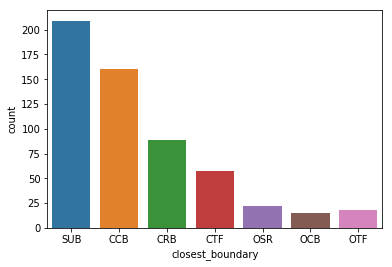

In [8]:
sns.countplot(boundary_distances["closest_boundary"])

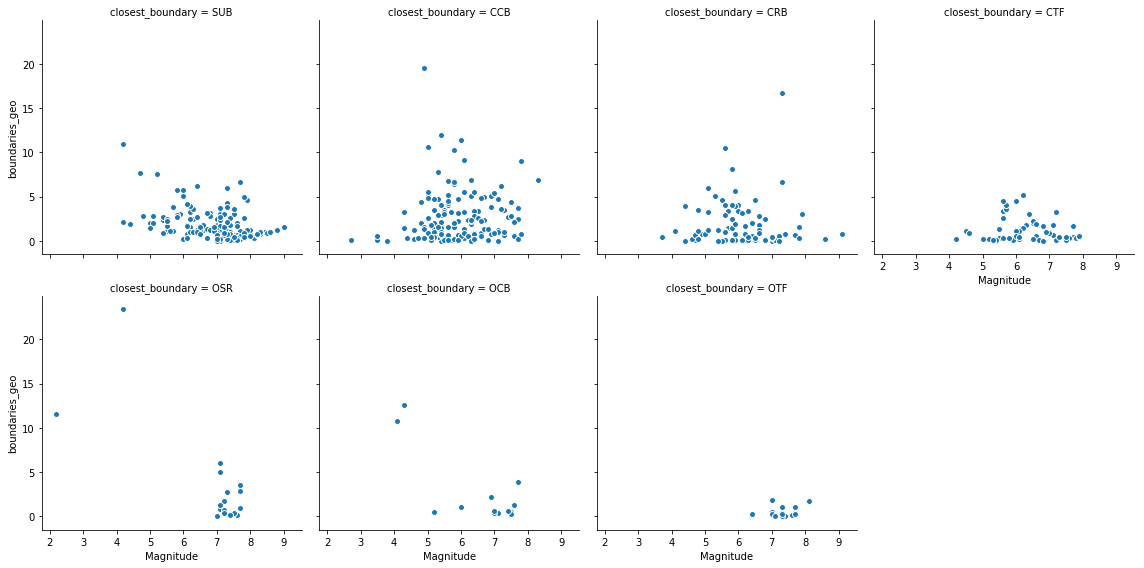

In [9]:
#plt.scatter(x=boundary_distances["Magnitude"], y=boundary_distances["boundaries_geo"])
#plt.scatter(x=boundary_distances["Magnitude"], y=boundary_distances["sub_geo"])
g = sns.FacetGrid(boundary_distances,  col = "closest_boundary", col_wrap=4, size = 4)
g = g.map(plt.scatter, "Magnitude", "boundaries_geo", edgecolor="w")

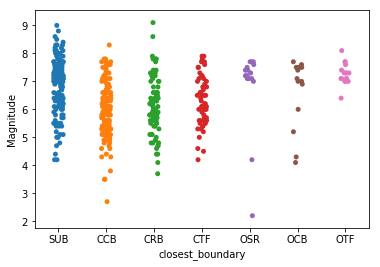

In [10]:
sns.stripplot(x="closest_boundary", y="Magnitude", data=boundary_distances, jitter=True)

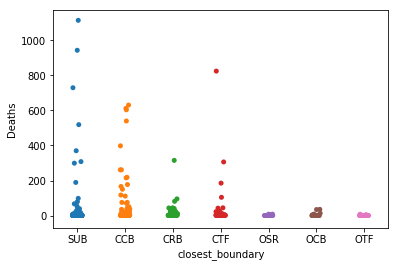

In [11]:
sns.stripplot(x="closest_boundary", y="Deaths", data=boundary_distances, jitter=True)

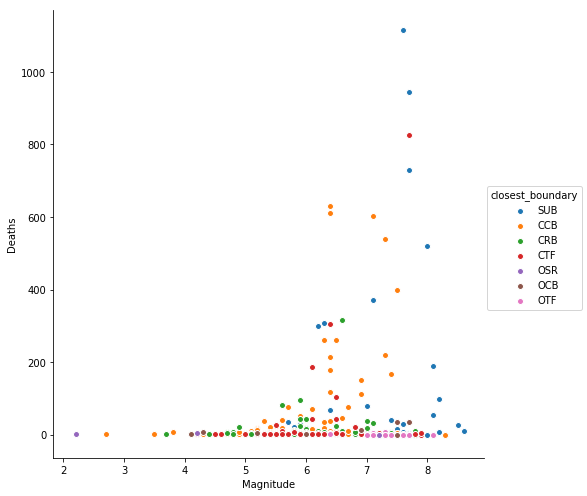

In [12]:
g2 = sns.FacetGrid(boundary_distances,  hue="closest_boundary", size = 7)
g2 = g2.map(plt.scatter, "Magnitude", "Deaths", edgecolor="w").add_legend()

earthquakes2_geo = earthquakes2_gdf["geometry"]
len(earthquakes2_geo)

def closest_boundary2(geoseries):
    min_distances = []
    
    for i, point in enumerate(earthquakes2_geo):
        min_dist = np.min([point.distance(line) for line in geoseries])
        min_distances.append(min_dist)
    return min_distances

dict_list = [boundaries_geo, sub_geo, ccb_geo, crb_geo, ctf_geo, ocb_geo, osr_geo, otf_geo]

total_min_distances2 = []

for geoseries in dict_list:
    min_distances = closest_boundary2(geoseries)
    total_min_distances2.append(min_distances)
    
total_min_distances2

min_dist = np.empty(len(earthquakes_gdf))
for i, point in enumerate(earthquakes_geo):
    min_dist[i] = np.min([point.distance(line) for line in sub_geo])
earthquakes_gdf['min_dist_to_lines_sub'] = min_dist
#earthquakes_gdf

In [13]:
boundary_sub = boundary_distances[boundary_distances["closest_boundary"]=="SUB"]
#boundary_sub.head()
#type(boundary_sub)
boundary_sub_gdf = gpd.GeoDataFrame(boundary_sub, crs = {'init': 'epsg:4326'})
#type(boundary_sub_gdf)
#type(boundary_sub_gdf.geometry)
#boundary_sub_gdf.crs

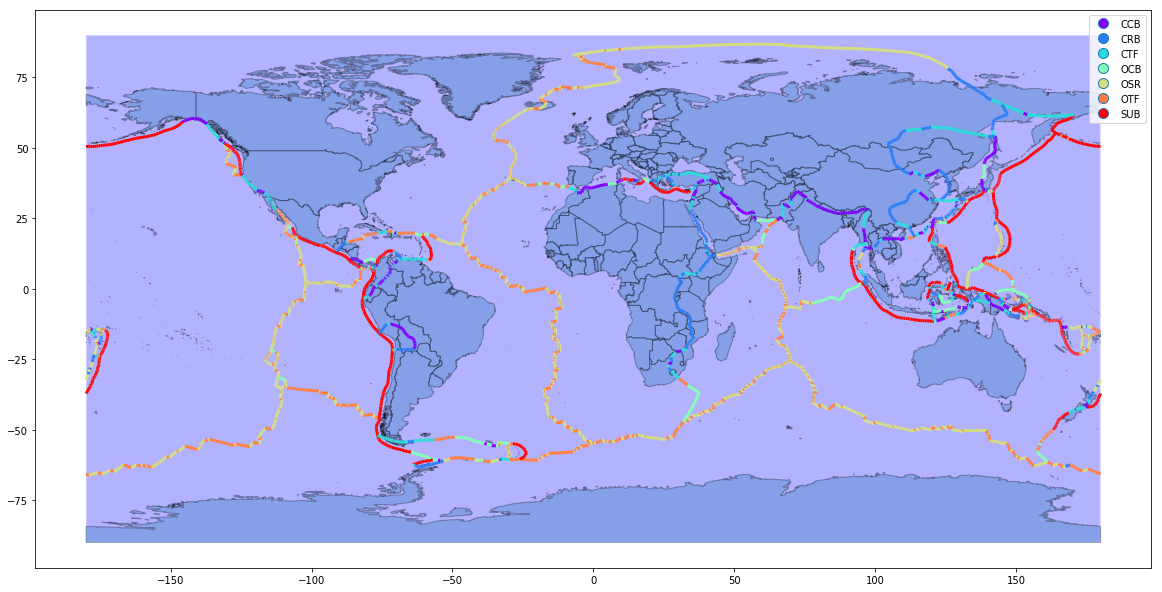

In [14]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
boundaries_gdf.plot(ax=ax, column = "STEPCLASS", cmap = "rainbow", lw = 3, legend = True)
boundary_sub_gdf.plot(ax=ax, markersize = 25, color = "black")

In [15]:
plates_gdf.crs

{'init': 'epsg:4326'}